# Simulation

This is all the code for the simulation of the market, including the traders, the asset and the market mechanism.

In [1]:
# Import relevant packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import pymarket
import networkx

,period,price,beta,10 MA,50 MA
0,-100,96.988088,1,NaN,NaN
1,-99,97.272129,1,NaN,NaN
2,-98,95.299544,1,NaN,NaN
3,-97,95.176754,1,NaN,NaN
4,-96,94.008399,1,NaN,NaN
...,...,...,...,...,...
95,-5,99.308995,1,99.844021,99.089219
96,-4,98.818393,1,99.679387,99.154423
97,-3,100.640194,1,99.653696,99.260414
98,-2,100.012704,1,99.524825,99.305151


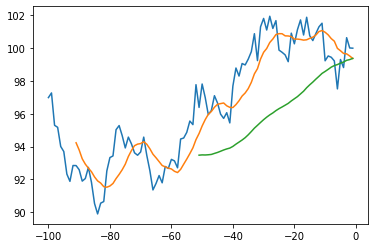

In [87]:
# Initialise the trading asset, as well as t previous random prices so that the technical analyst traders have some
# material to use to make their inital trading decisions. These random prices will be kept constant throughout the
# simulations so they don't affect the decisions of the traders between rounds. The price at t=0 will be 100 so price
# movements during the simulation are normalised to an index.

rm = 0.1 #Return on the market portfolio
rf = 0.02 #Return on the risk free asset

t = 100
period = []
start = -t

for i in range(t):
    period.append(start)
    start += 1
    
# asset_prices_rev = []
# price = 100

# for i in range(t):
    # asset_prices_rev.append(price)
    # price = price + np.random.normal(loc=-0.09, scale=1.0, size=None)
    
asset_prices_rev_final = [100, 100.01270443267846, 100.64019372161697, 98.81839318571531, 99.30899479777956, 97.51859080046586, 99.22427385535754, 99.44545557876086, 99.52622326159883, 99.23209122576705, 101.52132601414174, 101.30141646048006, 100.89710059388699, 100.46473999622577, 100.75961538456453, 101.88499554537094, 100.80411278857896, 101.72248034025961, 101.12565566539686, 100.26632483034365, 100.91562712976665, 99.17772539309188, 99.59066814732586, 99.75049301170291, 99.88257405096272, 101.67780729403768, 101.20291667999382, 101.94670634215417, 101.10767031065018, 101.81291988910793, 101.30365747376271, 99.2424041923615, 100.8833495441585, 99.78836505154021, 99.33535482264746, 98.97871646915819, 99.06522794959744, 98.30142009719744, 98.79170348115102, 97.6910991393464, 95.44595047877094, 96.06814982285735, 95.72056059028928, 95.98006873492281, 96.66174879041085, 97.10418900617363, 96.20190098646628, 95.95299800697686, 96.99590538116517, 97.81622741995606, 96.3887487724033, 97.77586186321399, 95.34063768966071, 95.55822196174113, 94.86914074199406, 94.52574130209447, 94.46441233699015, 92.7093912019743, 93.12968534010358, 93.2223145464527, 92.66989504822202, 92.78906639898042, 91.794571679981, 92.23728712947086, 91.7531808557108, 91.36069829889261, 92.5351177867759, 93.46525633285206, 94.57936577428167, 93.6743842774735, 93.47493406493045, 93.6252878884862, 94.17103159031704, 94.57988577655658, 93.92021148266691, 94.66830817347167, 95.2828076714649, 95.03199804355003, 93.43284668672827, 93.33299029582979, 92.51972813503856, 90.65244342293956, 90.55553325883402, 89.89860870807794, 90.5321278206722, 91.82820852517096, 92.73328391342815, 92.05545521924738, 91.89793090418809, 92.59268573869126, 92.84506087167615, 92.8490494107132, 91.88331933594272, 92.3255816844502, 93.70032141468926, 94.00839921394368, 95.17675414492784, 95.29954443407748, 97.27212940879878, 96.98808834932551]

asset_prices_rev_final.reverse()
asset_prices = asset_prices_rev_final
    
beta = []

for i in range(t):
    beta.append(1) #Assume beta has remained unchanged for previous periods
    
def moving_average(price_list, window): #Define a function to calculate simple moving averages
    
    window_size = window
    price_series = pd.Series(price_list)
    windows = price_series.rolling(window_size)
    ma = windows.mean()
    ma_list = ma.tolist()
    return ma_list
    
mas = moving_average(asset_prices, 10) #Generate shorter moving average
mal = moving_average(asset_prices, 50) #Generate longer moving average

assetdf = pd.DataFrame({"period": period, "price": asset_prices, "beta": beta, "10 MA": mas, "50 MA": mal})

plt.plot(period, asset_prices)
plt.plot(period, mas)
plt.plot(period, mal)

assetdf

In the next cell we define the different flavours of traders and the syntax of how they receive information and place orders accordingly. Flavours include simple and complex chartists, fundamentalists/arbitraguers, value traders and the traders of interest - the LSTM traders. 

Simple chartists use a simple moving average crossover strategy as a proxy for trend-following. The strength of the trend determines the bid/ask they are willing to place as well as the size of the order, to show the confidence the trader has in the trend.

In [127]:
# Define the different flavours of traders and the syntax of how they receive information and place orders accordingly.

class Trader:
        
    def __init__(self, flavour, firm):
        self.firm = firm # Firms will be given a higher starting endowment to trade with to represent higher market power.
        self.flavour = flavour
        
        if firm == True: self.bal = 1000000
        else: self.bal = 10000
        
    def placebid(self):
        if self.flavour == "schart":
            r1 = (assetdf.iloc[-1]["price"]-assetdf.iloc[-2]["price"])/(assetdf.iloc[-2]["price"])
            r2 = (assetdf.iloc[-2]["price"]-assetdf.iloc[-3]["price"])/(assetdf.iloc[-3]["price"])
            r3 = (assetdf.iloc[-3]["price"]-assetdf.iloc[-4]["price"])/(assetdf.iloc[-4]["price"])
            r = (r1 + r2 + r3)/3
            bidprice = assetdf.iloc[-1]["price"]*(1+r)
    
    def placeask(self):
        if self.flavour == "schart":
            r1 = (assetdf.iloc[-1]["price"]-assetdf.iloc[-2]["price"])/(assetdf.iloc[-2]["price"])
            r2 = (assetdf.iloc[-2]["price"]-assetdf.iloc[-3]["price"])/(assetdf.iloc[-3]["price"])
            r3 = (assetdf.iloc[-3]["price"]-assetdf.iloc[-4]["price"])/(assetdf.iloc[-4]["price"])
            r = (r1 + r2 + r3)/3
            askprice = assetdf.iloc[-1]["price"]*(1+r)
            print(askprice)
                        
    def trade(self):
        if self.flavour == "schart":
            if assetdf.iloc[-1]["10 MA"] > assetdf.iloc[-1]["50 MA"] and assetdf.iloc[-2]["10 MA"] < assetdf.iloc[-2]["50 MA"]:
                self.placebid()
            elif assetdf.iloc[-1]["10 MA"] < assetdf.iloc[-1]["50 MA"] and assetdf.iloc[-2]["10 MA"] > assetdf.iloc[-2]["50 MA"]:
                self.placeask()
            else: pass

100.40246131358724
